In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [92]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [93]:
folder_path = "/kaggle/input/emotionv7/facemo/images/" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [94]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/kaggle/input/emotionv7/facemo/images/train'
SIZE = (48,48) 
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 80

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 2827/2827 [00:07<00:00, 401.85it/s]


In [95]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [96]:
batch_size = 32
picture_size = SIZE
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    fill_mode='nearest')

In [97]:
train_generator = train_datagen.flow_from_directory(folder_path + 'train',
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path + 'validation',
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 2827 images belonging to 5 classes.
Found 797 images belonging to 5 classes.


In [98]:

from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


no_of_classes = 5

# Define the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add some trainable layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(no_of_classes, activation='softmax')(x)

# Define the model with the new layers
model = Model(inputs=base_model.input, outputs=predictions)

In [99]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=2,
                                verbose=1)

callbacks = [early_stopping, lr_scheduler]


In [100]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

last_epoch = 0
# Train the model on your dataset with a smaller learning rate
history = model.fit(train_generator, epochs=10, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 1/10
89/89 [==============================] - 16s 136ms/step - loss: 1.0628 - accuracy: 0.5936 - val_loss: 0.8352 - val_accuracy: 0.6675
Epoch 2/10
89/89 [==============================] - 11s 123ms/step - loss: 0.6446 - accuracy: 0.7545 - val_loss: 0.5301 - val_accuracy: 0.8193
Epoch 3/10
89/89 [==============================] - 10s 118ms/step - loss: 0.5436 - accuracy: 0.8030 - val_loss: 0.4863 - val_accuracy: 0.8218
Epoch 4/10
89/89 [==============================] - 10s 117ms/step - loss: 0.4402 - accuracy: 0.8327 - val_loss: 0.3492 - val_accuracy: 0.8858
Epoch 5/10
89/89 [==============================] - 11s 121ms/step - loss: 0.4044 - accuracy: 0.8387 - val_loss: 0.4056 - val_accuracy: 0.8444
Epoch 6/10
89/89 [==============================] - 10s 115ms/step - loss: 0.3516 - accuracy: 0.8751 - val_loss: 0.2749 - val_accuracy: 0.8971
Epoch 7/10
89/89 [==============================] - 11s 119ms/step - loss: 0.3426 - accuracy: 0.8737 - val_loss: 0.3035 - val_accuracy: 0.8908

In [103]:
# Unfreeze some of the layers in the base model
for layer in model.layers[-10:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

In [104]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

last_epoch = 10
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=30, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 11/30
89/89 [==============================] - 16s 148ms/step - loss: 0.2379 - accuracy: 0.9183 - val_loss: 0.1855 - val_accuracy: 0.9435
Epoch 12/30
89/89 [==============================] - 12s 139ms/step - loss: 0.1963 - accuracy: 0.9261 - val_loss: 0.1577 - val_accuracy: 0.9486
Epoch 13/30
89/89 [==============================] - 12s 137ms/step - loss: 0.1816 - accuracy: 0.9356 - val_loss: 0.1589 - val_accuracy: 0.9486
Epoch 14/30
89/89 [==============================] - 12s 133ms/step - loss: 0.1713 - accuracy: 0.9388 - val_loss: 0.0899 - val_accuracy: 0.9661
Epoch 15/30
89/89 [==============================] - 13s 142ms/step - loss: 0.1712 - accuracy: 0.9360 - val_loss: 0.1318 - val_accuracy: 0.9598
Epoch 16/30
89/89 [==============================] - 12s 134ms/step - loss: 0.1398 - accuracy: 0.9445 - val_loss: 0.0932 - val_accuracy: 0.9724

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 17/30
89/89 [==============================] - 13

In [105]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 2s 89ms/step - loss: 0.1084 - accuracy: 0.9661
Test accuracy: 0.9661229848861694


In [ ]:
model.save('/kaggle/working/my_model_emo.h5')

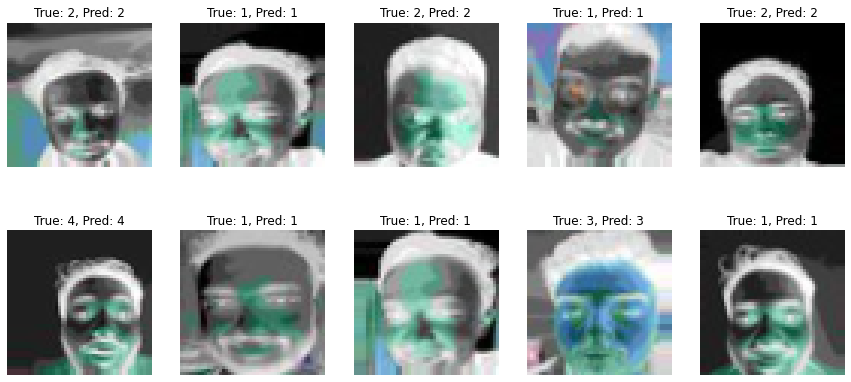

accuracy:  100.0


In [113]:
# Get a batch of 50 random images from the validation set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()
acc = 0
for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    if np.where(true_labels[i] == 1)[0] ==  pred_labels[i]:
        acc += 1
    axs[i].set_title(f'True: {np.where(true_labels[i] == 1)[0][0]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')
plt.show()
print("accuracy: ",(acc*100)/10)